In [1]:
import requests
import os
import pandas as pd

# GitHub repository owner and name
owner = "AMoazeni"
repo = "Machine-Learning-Image-Classification"

# Function to fetch contents of a directory from GitHub API
def get_github_directory_contents(owner, repo, path):
    url = f"https://api.github.com/repos/{owner}/{repo}/contents/{path}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch directory contents from GitHub API:", response.text)
        return []

# Function to download images
def download_images(image_urls, directory, name):
    os.makedirs(directory, exist_ok=True)
    for i, url in enumerate(image_urls):
        response = requests.get(url)
        if response.status_code == 200:
            image_path = os.path.join(directory, f"{name}_{i}.jpg")
            with open(image_path, 'wb') as f:
                f.write(response.content)
        else:
            print(f"Failed to download image from URL {url}")

# Fetch URLs of the cat images
url_cat = "Data/training_set/cats"
cat_set = get_github_directory_contents(owner, repo, url_cat)
cat_images = [content['download_url'] for content in cat_set if content['type'] == 'file' and content['name'].endswith('.jpg')]

# Fetch URLs of the dog images
url_dog = "Data/test_set/dogs"
dog_set = get_github_directory_contents(owner, repo, url_dog)
dog_images = [content['download_url'] for content in dog_set if content['type'] == 'file' and content['name'].endswith('.jpg')]

# Download cat images
download_images(cat_images[:1000], "cat_set", "cat")

# Download dog images
download_images(dog_images[:1000], "dog_set", "dog")

# Create dataframes with image paths
cat_image_paths = [f"cat_set/cat_{i}.jpg" for i in range(1000)]
dog_image_paths = [f"dog_set/dog_{i}.jpg" for i in range(1000)]

cat_df = pd.DataFrame({"image_path": cat_image_paths, "Target": 1})
dog_df = pd.DataFrame({"image_path": dog_image_paths, "Target": 0})


In [2]:
cat_df.shape, dog_df.shape

((1000, 2), (1000, 2))

In [3]:
# Concatenate the dataframes
cat_dog_df = pd.concat([cat_df, dog_df], ignore_index=True)

# Shuffle the combined dataframes
cat_dog_df = cat_dog_df.sample(frac=1).reset_index(drop=True)

cat_dog_df.shape

(2000, 2)

In [8]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog

# Define a function to preprocess images
def preprocess_image(image_path):
    img_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    hog_features = hog(new_img_array,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       visualize=False)
    return hog_features

In [9]:
# Initialize lists to store images and labels
X = []
y = []

# Iterate through each image path in the concatenated dataframe
for image_path in cat_dog_df['image_path']:
    # Preprocess the image and append to X
    X.append(preprocess_image(image_path))

# Convert X to a numpy array
X = np.array(X)

# Extract labels from the concatenated dataframe
y = cat_dog_df["Target"]

In [10]:
X.shape, y.shape

((2000, 2916), (2000,))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1600, 2916), (400, 2916), (1600,), (400,))

In [12]:
# Define a function to train a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def train_random_forest(X_train, y_train):
    rf_classifier = RandomForestClassifier(n_estimators=1000, criterion='gini', max_depth=5)
    rf_classifier.fit(X_train, y_train)
    return rf_classifier

In [17]:
# Train Random Forest classifiers
rf_classifier = train_random_forest(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

In [15]:
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)

Classification Accuracy: 0.66


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.65      0.66       206
           1       0.64      0.67      0.66       194

    accuracy                           0.66       400
   macro avg       0.66      0.66      0.66       400
weighted avg       0.66      0.66      0.66       400



In [18]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[136  70]
 [ 61 133]]


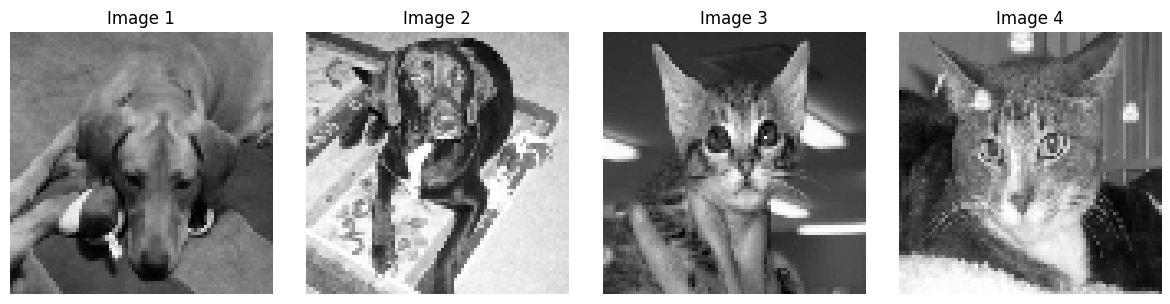

In [7]:
import matplotlib.pyplot as plt

# Define the number of images to display
num_images_to_display = 4

# Create a figure with subplots
fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 3))

# Iterate through the first num_images_to_display images
for i in range(num_images_to_display):
    # Display the image at index i
    axes[i].imshow(X[i], cmap="gray")
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(f"Image {i+1}")  # Set the title for each subplot

# Show the figure
plt.tight_layout()
plt.show()